In [1]:

import os
import shutil
import time
from collections import defaultdict


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from SALib.analyze import sobol


from ema_workbench import (
    Model, Policy, Scenario, MultiprocessingEvaluator,
    ema_logging
)
from ema_workbench.analysis import (
    feature_scoring, parcoords, pairs_plotting, prim
)
from ema_workbench.em_framework.evaluators import (
    BaseEvaluator, perform_experiments
)
from ema_workbench.em_framework.optimization import (
    ArchiveLogger, EpsilonProgress, EpsNSGAII,
    HyperVolume, epsilon_nondominated, to_problem
)
from ema_workbench.em_framework.outcomes import ScalarOutcome
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from pandas.api.types import is_numeric_dtype


from ema_workbench import Constraint
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import dimensional_stacking
from pandas.api.types import is_numeric_dtype, is_categorical_dtype

def get_do_nothing_dict():
    return {l.name: 0 for l in model.levers}





In [2]:
# Your lever names — make sure they exactly match model.levers
rfr_lever_names = [f"{area}_RfR {i}" for area in range(5) for i in range(3)]

# Constraint function
def max_one_rfr_total(*args):
    total = float(np.sum(args))  # ensures scalar
    violation = 0
    for i in range(0, len(args), 3):
        group_total = float(np.sum(args[i:i+3]))
        if group_total > 1:
            violation += group_total - 1
    return violation

# Constraint object
max_one_rfr_constraint = Constraint(
    "max_one_rfr_total",
    function=max_one_rfr_total,
    parameter_names=rfr_lever_names)

In [3]:
#Start with running baseline scenario
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)

    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        baseline = Policy("do_nothing", **get_do_nothing_dict())
        policies = [baseline]

        results = evaluator.perform_experiments(scenarios=1000, policies=policies)
        baseline_experiments, baseline_outcomes = results


INFO | pool started with 7 workers
INFO | performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [00:48<00:00, 20.76it/s]
INFO | experiments finished
INFO | terminating pool


## Running and showing the model

In [4]:
if __name__ == "__main__":

    # --- Load your model ---
    model, planning_steps = get_model_for_problem_formulation(3)



    reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "discount rate 0": 3.5,
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "ID flood wave shape": 4,
    }
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split("_")

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario("reference", **scen1)


    convergence_metrics = [

    EpsilonProgress(),
]

    espilon = [0.01] * len(model.outcomes)


    nfe = 15000

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=espilon,
            convergence=convergence_metrics,constraints=[max_one_rfr_constraint], reference=ref_scenario,

        )

INFO | pool started with 8 workers
100%|███████████████████████████████████▊| 14936/15000 [13:56<00:03, 16.58it/s]INFO | EpsNSGAII finished; Total NFE: 15036, Elapsed Time: 0:14:02.540624
15036it [14:02, 17.85it/s]                                                     
INFO | optimization completed, found 24 solutions
INFO | terminating pool


In [5]:
results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,0,1,0,0,0,0,1,0,0,0,...,1,5,2,1,7,4.784270e+07,0.000000,1.05,236500000.0,0.000000
1,0,1,0,0,0,0,1,0,0,0,...,2,4,2,4,7,4.784270e+07,0.000000,0.75,115300000.0,0.000000
2,0,0,0,0,0,0,1,0,0,0,...,6,7,7,7,7,3.358317e+07,0.013939,-0.60,30700000.0,1081.705371
3,0,1,0,0,0,0,1,0,0,0,...,5,7,4,0,0,3.358317e+07,0.013939,-0.25,115300000.0,1081.705371
4,0,1,0,0,0,0,1,0,0,0,...,2,5,4,7,7,3.358317e+07,0.005808,-0.25,115300000.0,1795.799932
5,0,0,0,0,0,0,1,0,0,0,...,4,1,10,7,6,2.870500e+07,0.011860,-0.60,30700000.0,1421.353034
6,0,0,0,0,0,0,1,0,0,0,...,2,4,1,4,4,2.326521e+07,0.009609,0.75,151900000.0,1245.985636
7,0,1,0,0,0,0,1,0,0,0,...,2,6,3,7,5,2.919412e+07,0.012099,1.05,236500000.0,940.753904
8,0,1,0,0,0,0,1,0,0,0,...,2,7,7,3,6,2.919412e+07,0.033610,1.05,236500000.0,0.000000
9,0,0,0,0,0,0,1,0,0,0,...,2,1,1,5,4,1.894867e+07,0.021396,0.40,30700000.0,0.000000


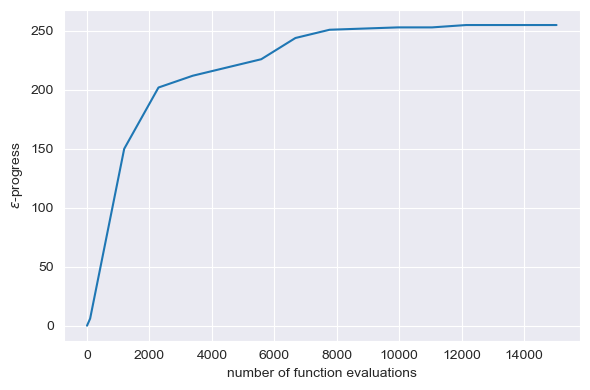

In [6]:
fig, ax1 = plt.subplots(figsize=(6, 4))  # no ncols=2

ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel(r'$\epsilon$-progress')
ax1.set_xlabel('number of function evaluations')
plt.savefig("convergence enkel MORDM.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()



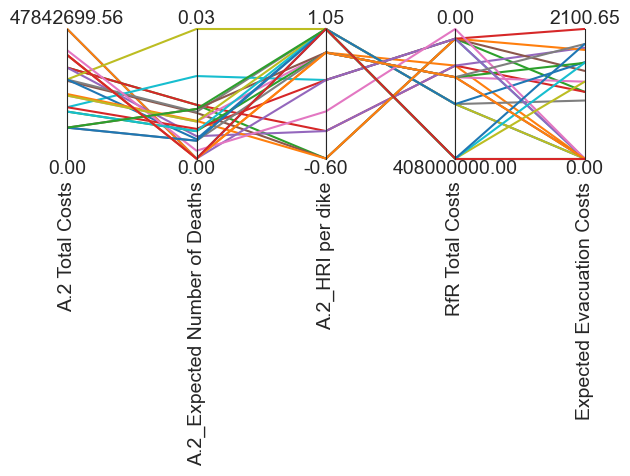

<Figure size 1400x1000 with 0 Axes>

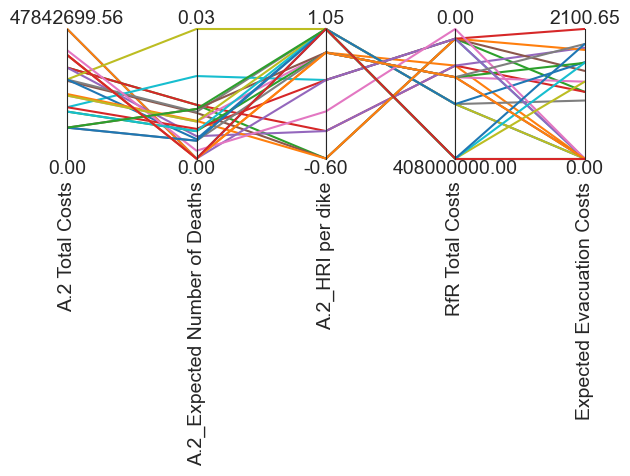

In [7]:
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths', 'RfR Total Costs',"Expected Evacuation Costs"]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))  # width=12 inches, height=8 inches

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Invert specific axis
paraxes.invert_axis("RfR Total Costs")

# Save the plot
plt.savefig("mordm_parallel coordinates all.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [8]:
logical = (
    (results["A.2 Total Costs"] < 2e8) &

    (results["A.2_HRI per dike"] > 0.7))



np.sum(logical)

15

/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_6145/959764074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_1["policy"] = results_1.index  # Automatically uses 16, 17, 18 in your case


<Figure size 1400x1000 with 0 Axes>

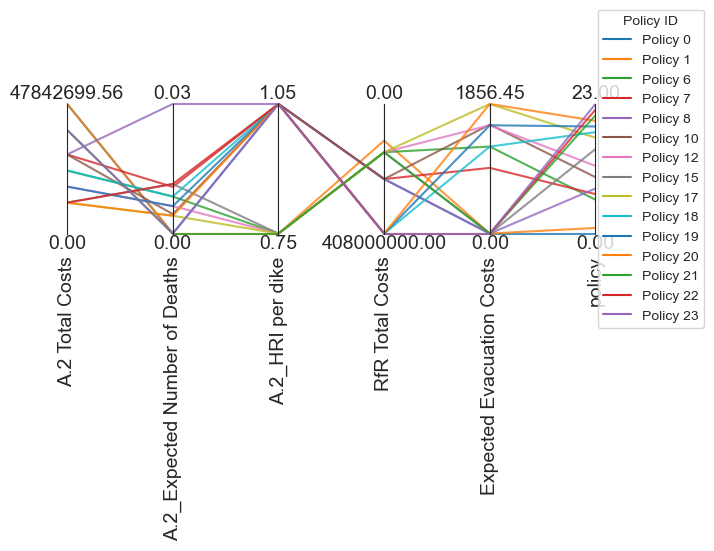

In [9]:
results_1 = results[logical]
results_1["policy"] = results_1.index  # Automatically uses 16, 17, 18 in your case


data = results_1.loc[:, [o.name for o in model.outcomes] + ['policy']]


limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths',
               'RfR Total Costs', 'Expected Evacuation Costs']] = 0


policy_ids = data["policy"].unique()
colors = sns.color_palette("tab10", len(policy_ids))
color_map = dict(zip(policy_ids, colors))


plt.figure(figsize=(14, 10))
paraxes = parcoords.ParallelAxes(limits)

# Plot each policy row with its assigned color
for _, row in data.iterrows():
    policy_id = row["policy"]
    color = color_map.get(policy_id, "gray")
    paraxes.plot(row.to_frame().T, color=color, alpha=0.8)

# Invert axis if needed
paraxes.invert_axis("RfR Total Costs")

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color=color_map[pid], label=f"Policy {pid}")
    for pid in policy_ids
]
plt.legend(handles=legend_handles, title="Policy ID", loc="center left",bbox_to_anchor=(1.02, 0.5),borderaxespad=0)


plt.savefig("parallel_coords_MORDM_selected_policies.png", dpi=300, bbox_inches='tight')
plt.show()

## optimized policies

In [10]:
policies = results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,1,0,0,0,0,1,0,0,0,...,0,6,3,4,0,1,5,2,1,7
1,0,1,0,0,0,0,1,0,0,0,...,0,7,5,7,6,2,4,2,4,7
6,0,0,0,0,0,0,1,0,0,0,...,0,9,4,0,6,2,4,1,4,4
7,0,1,0,0,0,0,1,0,0,0,...,0,6,1,6,5,2,6,3,7,5
8,0,1,0,0,0,0,1,0,0,0,...,0,6,3,4,6,2,7,7,3,6
10,0,1,0,0,0,0,1,0,0,0,...,0,6,6,7,6,1,7,6,4,5
12,0,0,0,0,0,0,1,0,0,0,...,0,7,0,5,7,1,1,5,7,7
15,0,0,0,0,0,0,1,0,0,0,...,0,2,1,7,6,3,5,4,0,5
17,0,0,0,0,0,0,1,0,0,0,...,0,5,0,1,7,6,2,5,7,5
18,0,0,0,0,0,0,1,0,0,0,...,0,4,4,2,7,1,2,5,6,5


In [11]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [12]:
#Create policy dataframe
lever_names = [l.name for l in model.levers]
#policies_df = results[lever_names]
policies.to_csv("candidate_policies.csv", index=False)

## Testing out the policies

In [13]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

INFO | pool started with 8 workers
INFO | performing 1000 scenarios * 15 policies * 1 model(s) = 15000 experiments
100%|████████████████████████████████████| 15000/15000 [14:12<00:00, 17.60it/s]
INFO | experiments finished
INFO | terminating pool


In [14]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [15]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,6.998928e+15,0.002039,2.520504,236500000.0,0.000000e+00
1,8.184449e+15,0.002631,1.609357,115300000.0,0.000000e+00
10,2.816719e+16,0.000483,1.026970,236500000.0,6.203032e+07
12,1.980602e+16,0.001945,0.520104,151900000.0,4.189071e+07
15,1.781132e+16,0.013452,0.782061,151900000.0,0.000000e+00
17,1.781132e+16,0.001743,0.782061,151900000.0,5.246791e+07
18,2.342320e+16,0.002299,1.032533,408000000.0,3.172482e+07
19,1.980602e+16,0.001945,1.120224,408000000.0,4.217066e+07
20,1.781132e+16,0.001743,1.402744,408000000.0,5.153250e+07
21,1.403390e+16,0.006467,1.170246,151900000.0,0.000000e+00


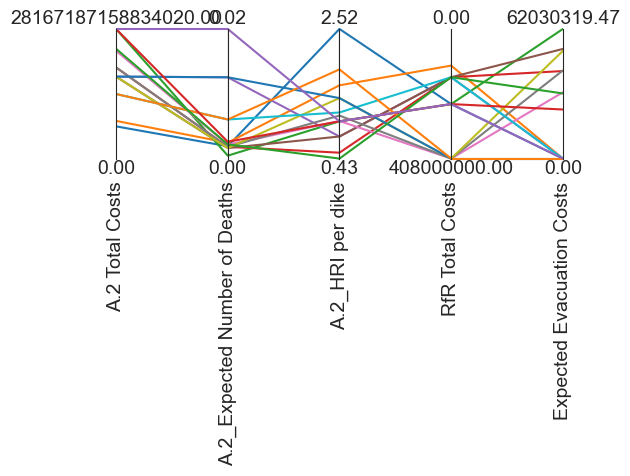

<Figure size 1400x1000 with 0 Axes>

In [16]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths', 'RfR Total Costs',"Expected Evacuation Costs"]] = 0


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
plt.figure(figsize=(14, 10))
plt.savefig("scores_single_MORDM.png", dpi=300, bbox_inches='tight') # width=12 inches, height=8 inches
plt.show()

In [17]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [18]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

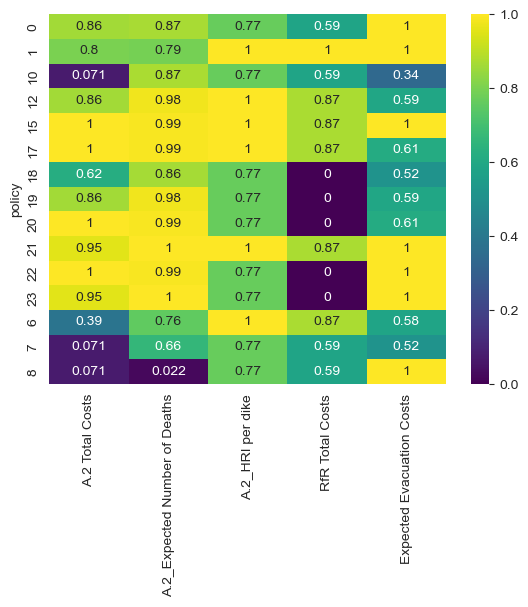

In [19]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("regret_single_MORDM.png", dpi=300, bbox_inches='tight')
plt.show()

In [20]:

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

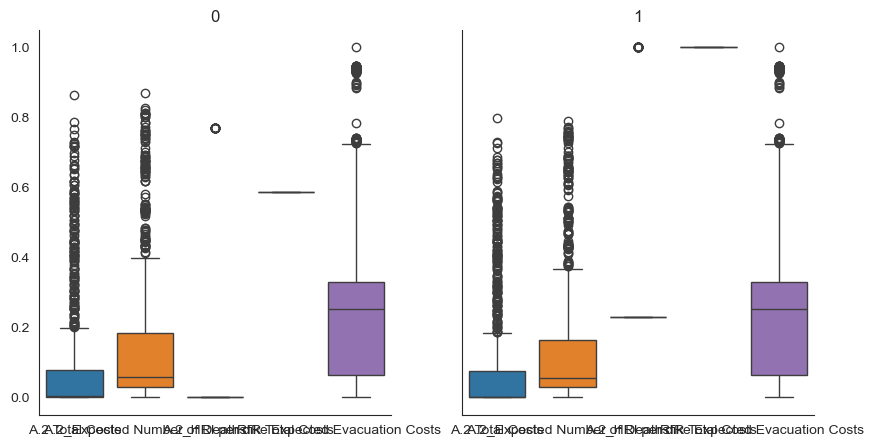

In [21]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5),
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this.


# zip allows us to zip together the list of axes and the list of
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    # removes top and left hand black outline of axes
    sns.despine()

    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

## Selecteren scenarios maar gaan we doen met PRIM

In [22]:
policies_df = pd.read_csv("candidate_policies.csv")

# zet elke rij om in een Policy-object
candidate_policies = [
    Policy(f"cand_{i}", **row.to_dict())
    for i, row in policies_df.iterrows()

    ]

In [23]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)
    scenarios=1000
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=candidate_policies )

        experiments, outcomes = results

INFO | pool started with 7 workers
INFO | performing 1000 scenarios * 15 policies * 1 model(s) = 15000 experiments
100%|████████████████████████████████████| 15000/15000 [16:00<00:00, 15.62it/s]
INFO | experiments finished
INFO | terminating pool


In [24]:
hri_sys = outcomes["A.2_HRI per dike"]
hri_q25 = np.percentile(hri_sys, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
ead_total = outcomes["A.2 Total Costs"] # (N,)
ead_q75 = np.percentile(ead_total, 75)
target_ead = ead_total >= ead_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

        # ---- 2.4 Combineer tot één worst-case target ----
y = target_hri | target_ead        # booleaanse vector (N,)


# hri_baseline=baseline_outcomes["A.2_HRI per dike"]
# hri_sys = outcomes["A.2_HRI per dike"]
# hri_q25 = np.percentile(hri_baseline, 25)# (N,) systeembreed
# target_hri = hri_sys <= hri_q25
#
#         # ---- 2.2 Expected Annual Damage ----
# cost_baseline=baseline_outcomes["A.2 Total Costs"]
# cost_total = outcomes["A.2 Total Costs"] # (N,)
# cost_q75 = np.percentile(cost_baseline, 75)
# target_cost = cost_total >= cost_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

#         # ---- 2.4 Combineer tot één worst-case target ----
# y = target_hri | target_cost
# y

print(f"worst-cases: {y.sum()} van {n_scenarios*policies} runs  ({y.mean()*100:.1f} %)")

        # Determine model uncertainties
cols_unc = [u.name for u in model.uncertainties]
X = experiments[cols_unc]

#Start PRIM
prim_alg = prim.Prim(
            X, y,
            threshold=0.80,
        )

print("Aantal opgeslagen boxen:", len(prim_alg.boxes))

worst-cases: 6183 van     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         0     1000        0        0        0        0     1000        0   
1         0     1000        0        0        0        0     1000        0   
6         0        0        0        0        0        0     1000        0   
7         0     1000        0        0        0        0     1000        0   
8         0     1000        0        0        0        0     1000        0   
10        0     1000        0        0        0        0     1000        0   
12        0        0        0        0        0        0     1000        0   
15        0        0        0        0        0        0     1000        0   
17        0        0        0        0        0        0     1000        0   
18        0        0        0        0        0        0     1000        0   
19        0        0        0        0        0        0     1000        0   
20        0        0        0        0    

INFO | 15000 points remaining, containing 6183 cases of interest
INFO | mean: 0.994017094017094, mass: 0.078, coverage: 0.188096393336568, density: 0.994017094017094 restricted_dimensions: 5


coverage       0.188096
density        0.994017
id            52.000000
k           1163.000000
mass           0.078000
mean           0.994017
n           1170.000000
res_dim        5.000000
Name: 52, dtype: float64

                          box 52                                         
                             min              max      qp value  qp value
A.2_pfail               0.000579          0.16311           NaN  0.000000
A.2_Bmax               30.209177       337.532397           NaN  0.598714
A.1_pfail               0.389366         0.999454  6.817357e-25       NaN
discount rate 2  {1.5, 2.5, 3.5}  {1.5, 2.5, 3.5}  4.979080e-02       NaN
A.3_Bmax               37.205469       349.944824  4.667531e-01       NaN



/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{1.5, 2.5, 3.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


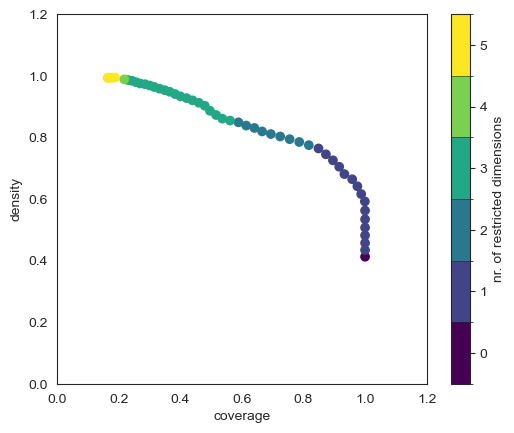

53 stappen in deze box


In [25]:
# A) De “beste” box volgens je threshold
box = prim_alg.find_box()
box.inspect()
box.show_tradeoff()
plt.show()# geeft een PrimBox terug
traj = box.peeling_trajectory
print(len(traj), "stappen in deze box")

[<Figure size 640x480 with 1 Axes>]

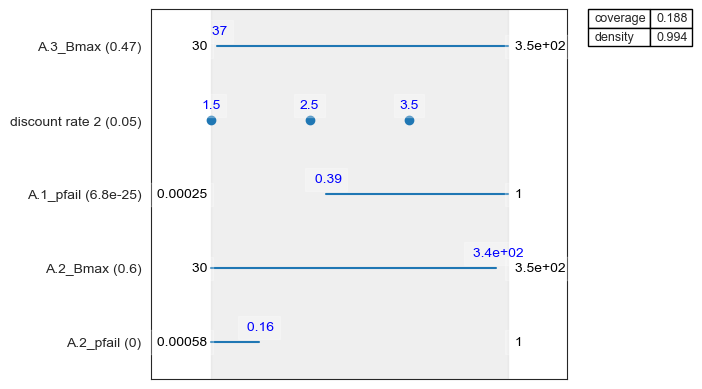

In [26]:
# en inspecteer 'm meteen
box.inspect( style="graph" )

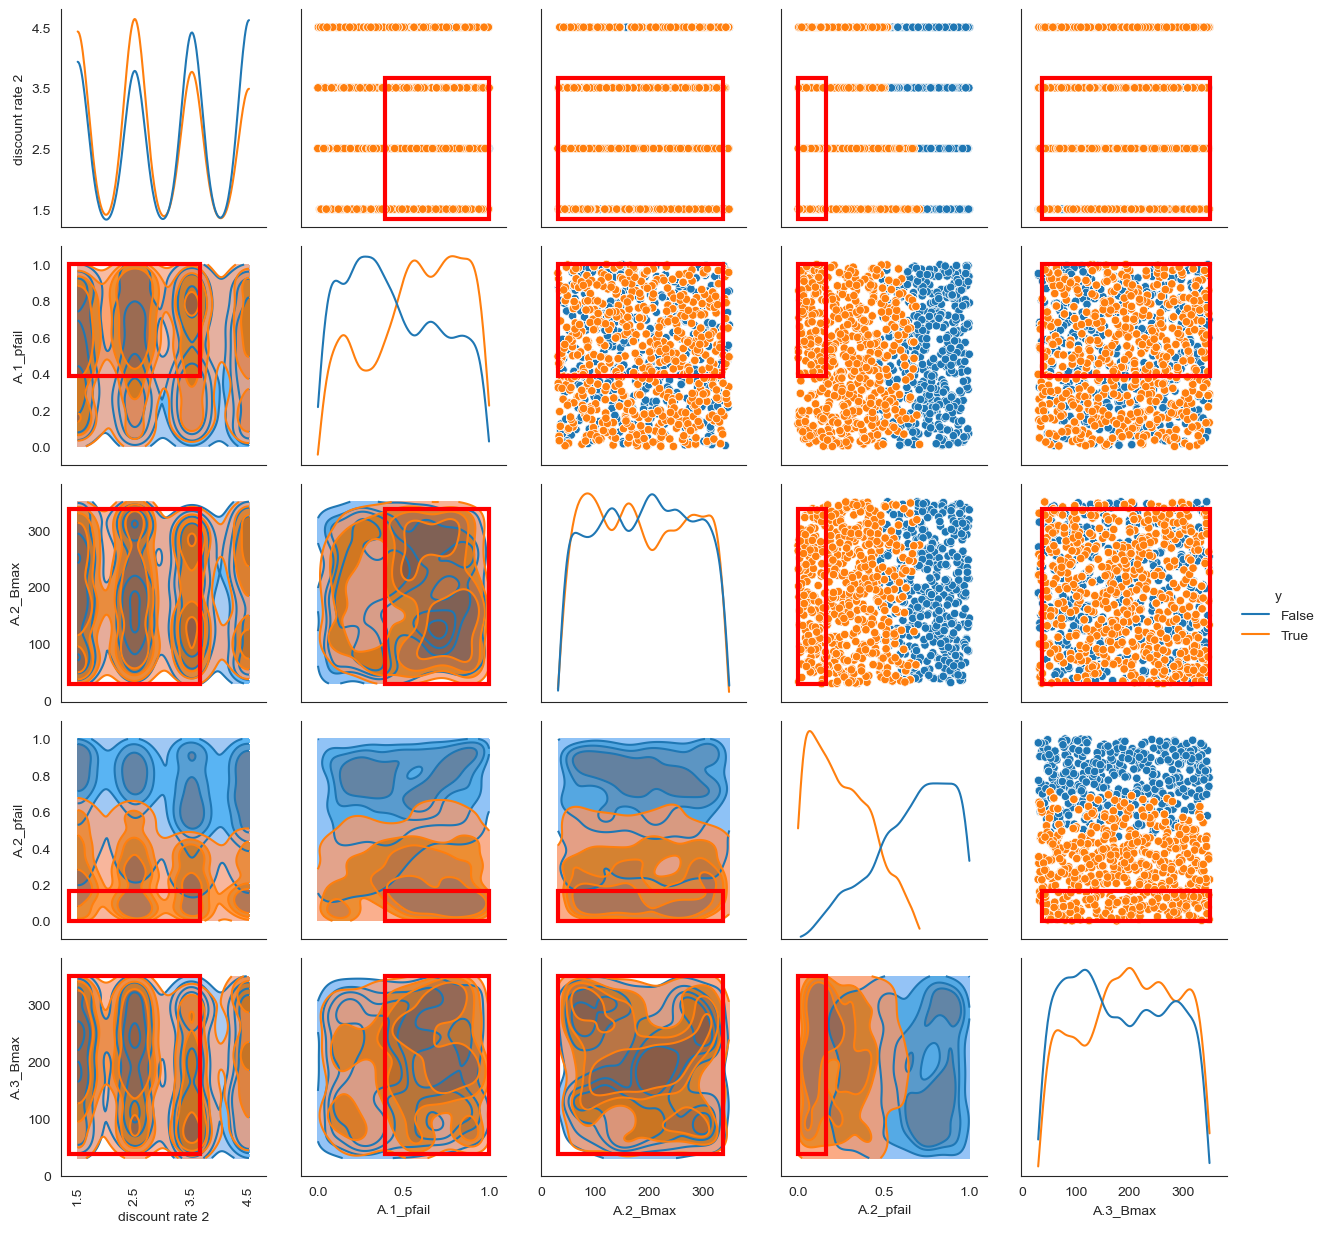

In [27]:
fig = box.show_pairs_scatter()
plt.show()

INFO | model dropped from analysis because only a single category


origineel aantal kolommen: 53
zonder levers           : 22


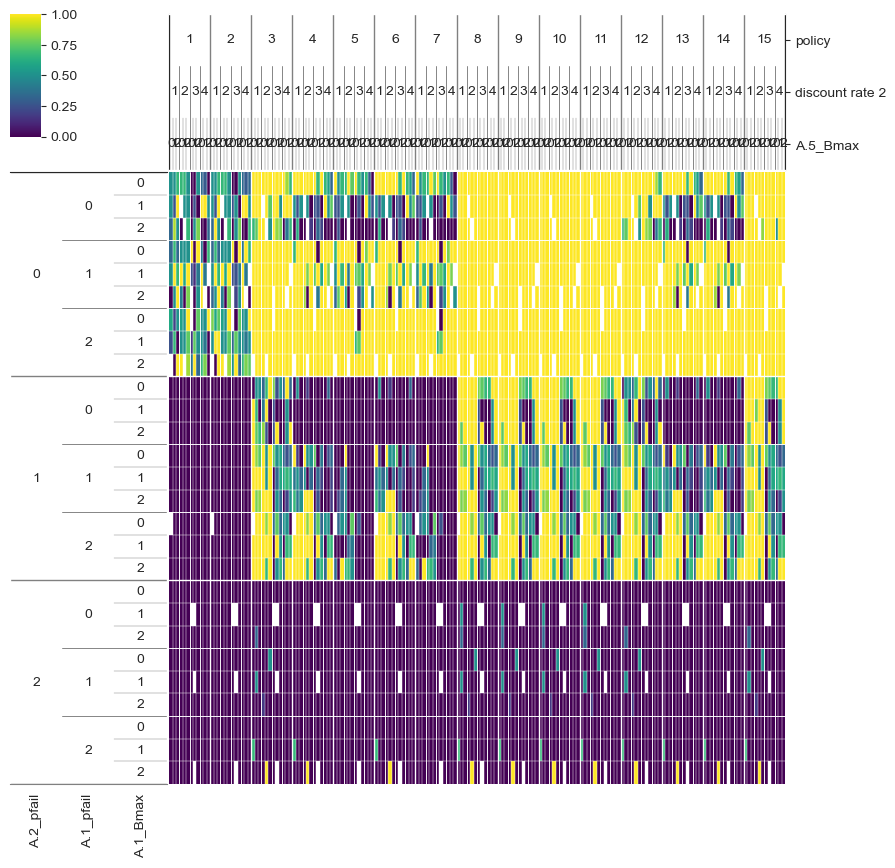

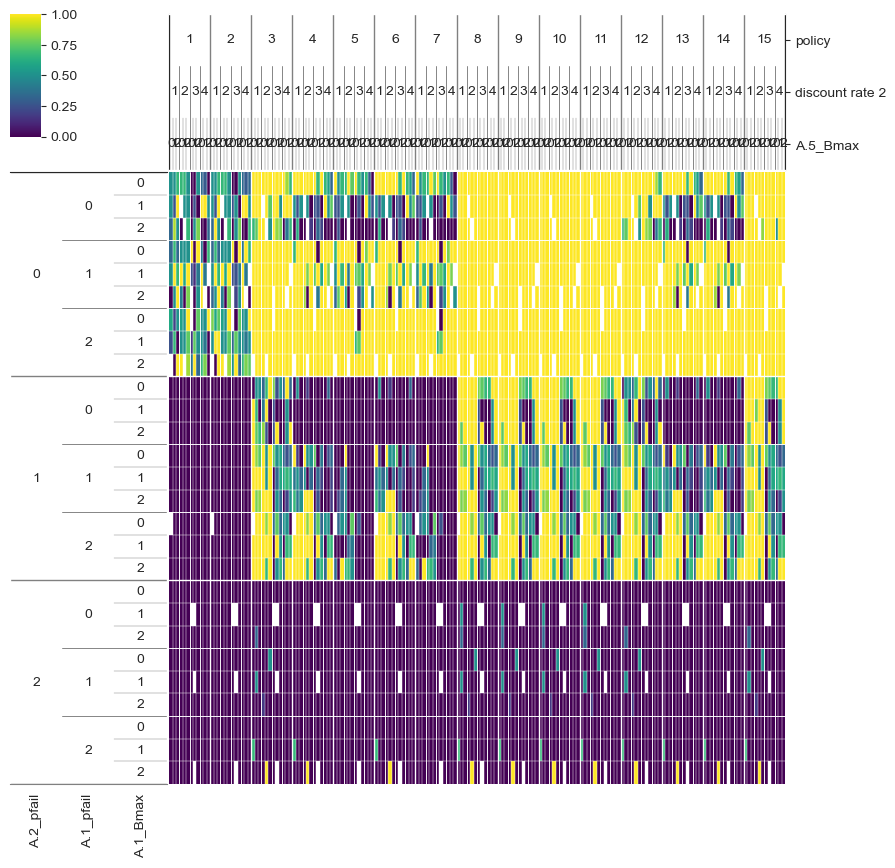

In [28]:
lever_names = [lev.name for lev in model.levers]
experiments_unc = experiments.drop(columns=lever_names)


# even checken:
print("origineel aantal kolommen:", experiments.shape[1])
print("zonder levers           :", experiments_unc.shape[1])

dimensional_stacking.create_pivot_plot(experiments_unc, y)


In [29]:

# 1) Haal de grenzen op uit de box (list met één entry per box in je peeling_trajectory)
raw_limits = box.box_lims[0]

# 1) Transponeren, zodat elke var een rij wordt, en de kolommen 0 en 1 zijn
df_lim = raw_limits.T

# 2) Hernoemen van de kolommen 0→min en 1→max
df_lim = df_lim.rename(columns={0: "min", 1: "max"})

# 3) (optioneel) zet de index-naam netjes
df_lim.index.name = "var"

In [30]:
df_lim
mask = pd.Series(True, index=experiments.index)

for var, row in df_lim.iterrows():
    lo, hi = row["min"], row["max"]
    ser = experiments[var]

    if is_numeric_dtype(ser):
        # voor numerieke parameters
        mask &= ser.between(lo, hi)
    else:
        # voor categorische parameters
        # lo kan een set/list zijn, of een enkele waarde
        if isinstance(lo, (set, list)):
            mask &= ser.isin(lo)
        else:
            mask &= (ser == lo)

exp_in_box = experiments[mask]
out_in_box = {
    name: array[mask.values]  # .values is een numpy‐boolean array
    for name, array in outcomes.items()
}

In [31]:
expanded = {}
for name, arr in out_in_box.items():
    if arr.ndim == 1:
        # gewoon een vector
        expanded[name] = arr
    else:
        # maak per tijdstap een kolom
        T = arr.shape[1]
        for t in range(T):
            expanded[f"{name}_{t}"] = arr[:, t]

out_df = pd.DataFrame(expanded)

In [32]:
exp_in_box['worst_case']=y[exp_in_box.index]
true_worst= exp_in_box[exp_in_box['worst_case']]
#
# true_worst = true_worst.assign(
#     total_cost = out_in_box['A.2 Total Costs']
# )

In [33]:
# --- 1) Maak één Series van alle total costs, met de originele index ---
all_costs = pd.Series(
    out_in_box['A.2 Total Costs'],       # numpy array voor _alle_ runs in out_in_box
    index = exp_in_box.index              # die hoort dezelfde lengte en index labels te hebben
)

# --- 2) Filter die Series naar alleen de worst‐case subset (true_worst.index) ---
worst_costs = all_costs.loc[true_worst.index]

# --- 3) Wijs die gefilterde Series toe als nieuwe kolom ---
true_worst = true_worst.assign(total_costs=worst_costs)

In [34]:
true_worst['total_costs'] = pd.Series(
    out_in_box['A.2 Total Costs'],
    index=exp_in_box.index
).loc[true_worst.index]

In [35]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs
0,22,98.773822,10.0,0.657850,158.522733,10.0,0.009843,53.744328,1.0,0.822330,...,1,5,2,1,7,2000,cand_0,dikesnet,True,5.895509e+08
3,119,240.502512,1.0,0.400522,228.365644,1.0,0.011871,176.941044,1.5,0.780876,...,1,5,2,1,7,2003,cand_0,dikesnet,True,6.071874e+08
8,89,215.169118,1.5,0.620619,64.604829,1.0,0.020883,291.213955,10.0,0.589696,...,1,5,2,1,7,2008,cand_0,dikesnet,True,4.080175e+08
13,81,40.505881,10.0,0.042344,110.493878,1.0,0.043827,288.836137,10.0,0.659246,...,1,5,2,1,7,2013,cand_0,dikesnet,True,2.759319e+08
19,89,174.538092,1.0,0.910379,110.834815,1.0,0.130762,328.921013,1.0,0.979559,...,1,5,2,1,7,2019,cand_0,dikesnet,True,8.965344e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14964,8,186.294453,1.5,0.360397,90.085488,10.0,0.016749,166.509212,1.0,0.725908,...,1,5,5,0,9,2964,cand_14,dikesnet,True,1.083584e+09
14980,42,86.002555,1.0,0.053552,102.900462,10.0,0.050528,186.739725,1.0,0.243863,...,1,5,5,0,9,2980,cand_14,dikesnet,True,2.109227e+08
14987,83,42.161912,10.0,0.721146,281.799501,10.0,0.083472,224.772823,1.5,0.273338,...,1,5,5,0,9,2987,cand_14,dikesnet,True,2.911852e+08
14993,74,80.387082,10.0,0.778859,328.140701,1.0,0.220417,275.185307,1.5,0.802754,...,1,5,5,0,9,2993,cand_14,dikesnet,True,1.500765e+08


In [36]:
# --- 1) Maak één Series van alle total costs, met de originele index ---
all_costs = pd.Series(
    out_in_box['A.2_HRI per dike'],       # numpy array voor _alle_ runs in out_in_box
    index = exp_in_box.index              # die hoort dezelfde lengte en index labels te hebben
)

# --- 2) Filter die Series naar alleen de worst‐case subset (true_worst.index) ---
worst_HRI = all_costs.loc[true_worst.index]

# --- 3) Wijs die gefilterde Series toe als nieuwe kolom ---
true_worst = true_worst.assign(HRI=worst_HRI)

In [37]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs,HRI
0,22,98.773822,10.0,0.657850,158.522733,10.0,0.009843,53.744328,1.0,0.822330,...,5,2,1,7,2000,cand_0,dikesnet,True,5.895509e+08,0.05
3,119,240.502512,1.0,0.400522,228.365644,1.0,0.011871,176.941044,1.5,0.780876,...,5,2,1,7,2003,cand_0,dikesnet,True,6.071874e+08,0.05
8,89,215.169118,1.5,0.620619,64.604829,1.0,0.020883,291.213955,10.0,0.589696,...,5,2,1,7,2008,cand_0,dikesnet,True,4.080175e+08,0.05
13,81,40.505881,10.0,0.042344,110.493878,1.0,0.043827,288.836137,10.0,0.659246,...,5,2,1,7,2013,cand_0,dikesnet,True,2.759319e+08,0.05
19,89,174.538092,1.0,0.910379,110.834815,1.0,0.130762,328.921013,1.0,0.979559,...,5,2,1,7,2019,cand_0,dikesnet,True,8.965344e+07,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14964,8,186.294453,1.5,0.360397,90.085488,10.0,0.016749,166.509212,1.0,0.725908,...,5,5,0,9,2964,cand_14,dikesnet,True,1.083584e+09,0.05
14980,42,86.002555,1.0,0.053552,102.900462,10.0,0.050528,186.739725,1.0,0.243863,...,5,5,0,9,2980,cand_14,dikesnet,True,2.109227e+08,0.05
14987,83,42.161912,10.0,0.721146,281.799501,10.0,0.083472,224.772823,1.5,0.273338,...,5,5,0,9,2987,cand_14,dikesnet,True,2.911852e+08,0.05
14993,74,80.387082,10.0,0.778859,328.140701,1.0,0.220417,275.185307,1.5,0.802754,...,5,5,0,9,2993,cand_14,dikesnet,True,1.500765e+08,0.05


In [38]:
# 1) min-max schaal HRI en costs
hri = true_worst['HRI']
cost = true_worst['total_costs']

hri_scaled = (hri - hri.min()) / (hri.max() - hri.min())
cost_scaled = (cost - cost.min()) / (cost.max() - cost.min())

# 2) keer de costs om
inv_cost = 1 - cost_scaled

# 3) bereken de samengestelde score
score = hri_scaled * inv_cost

# 4) voeg toe aan true_worst
true_worst = true_worst.assign(
    hri_scaled = hri_scaled,
    cost_scaled = cost_scaled,
    inv_cost    = inv_cost,
    score       = score
)

true_worst.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,scenario,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
0,22,98.773822,10.0,0.657850,158.522733,10.0,0.009843,53.744328,1.0,0.822330,...,2000,cand_0,dikesnet,True,5.895509e+08,0.05,0.3,0.435405,0.564595,0.169379
3,119,240.502512,1.0,0.400522,228.365644,1.0,0.011871,176.941044,1.5,0.780876,...,2003,cand_0,dikesnet,True,6.071874e+08,0.05,0.3,0.448664,0.551336,0.165401
8,89,215.169118,1.5,0.620619,64.604829,1.0,0.020883,291.213955,10.0,0.589696,...,2008,cand_0,dikesnet,True,4.080175e+08,0.05,0.3,0.298921,0.701079,0.210324
13,81,40.505881,10.0,0.042344,110.493878,1.0,0.043827,288.836137,10.0,0.659246,...,2013,cand_0,dikesnet,True,2.759319e+08,0.05,0.3,0.199614,0.800386,0.240116
19,89,174.538092,1.0,0.910379,110.834815,1.0,0.130762,328.921013,1.0,0.979559,...,2019,cand_0,dikesnet,True,8.965344e+07,0.05,0.3,0.059563,0.940437,0.282131


In [39]:
# # 1) voeg y als kolom toe
# exp_in_box = exp_in_box.copy()
# exp_in_box['worst_case'] = y[exp_in_box.index]
#
# # 2) houd alleen echte worst-cases over
# true_worst = exp_in_box[exp_in_box['worst_case']]

# 3) kies uit true_worst je max/min/median voor EAD & HRI
best  = true_worst.nlargest(1, 'score')   #best case is hoogste
worst = true_worst.nsmallest(1,  'score')      #worst case is laagste
mid   = true_worst.iloc[[len(true_worst)//2]]

In [40]:
# 1) knijp de rij samen naar een Series
best_s   = best.iloc[0]  # of .iloc[0]
mid_s = mid.iloc[0]
worst_s  = worst.iloc[0]



df_scenarios = pd.DataFrame([
    best_s.to_dict(),
    mid_s.to_dict(),
    worst_s.to_dict()
], index=["best_case", "median_case", "worst_case"])

df_scenarios = (
    df_scenarios
    .rename(columns={"scenario.1": "scenario"})  # als hij zo heet
    .set_index("scenario")                        # zet de kolom als index
)

In [41]:
df_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 2,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
scenario,,,,,,,,,,,,,,,,,,,,,
2185,46,299.626396,10.0,0.927676,147.355643,10.0,0.175216,256.938993,1.0,0.937979,...,7,cand_1,dikesnet,True,8.517800e+07,0.75,1.0,0.056198,0.943802,0.943802
2923,72,322.335666,1.5,0.310314,325.966285,1.5,0.482606,128.673924,1.5,0.269525,...,7,cand_6,dikesnet,True,2.091047e+07,-0.25,0.0,0.007879,0.992121,0.000000
2000,22,98.773822,10.0,0.657850,158.522733,10.0,0.009843,53.744328,1.0,0.822330,...,7,cand_1,dikesnet,True,6.732112e+08,-0.25,0.0,0.498304,0.501696,0.000000


In [42]:
df_scenarios.to_csv("reference_scenarios.csv", index_label="scenario")


In [43]:
candidate_scenarios = [
    Scenario(f"scenario_{idx}", **row.to_dict())
    for idx, row in df_scenarios.iterrows()
]

In [44]:
for scenario in candidate_scenarios:
    print(scenario)

Scenario({'A.0_ID flood wave shape': 46, 'A.1_Bmax': 299.6263964974943, 'A.1_Brate': 10.0, 'A.1_pfail': 0.9276758286978589, 'A.2_Bmax': 147.35564265553634, 'A.2_Brate': 10.0, 'A.2_pfail': 0.17521580939694764, 'A.3_Bmax': 256.9389927325969, 'A.3_Brate': 1.0, 'A.3_pfail': 0.9379785399405558, 'A.4_Bmax': 207.0201859296431, 'A.4_Brate': 1.5, 'A.4_pfail': 0.7194992845845408, 'A.5_Bmax': 84.44305509159486, 'A.5_Brate': 1.5, 'A.5_pfail': 0.7954995158355136, 'discount rate 0': 1.5, 'discount rate 1': 1.5, 'discount rate 2': 3.5, '0_RfR 0': 0, '0_RfR 1': 1, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 4, 'A.1_DikeIncrease 1': 3, 'A.1_DikeIncrease 2': 2, 'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 7, 'A.3_DikeIncrease 1': 5, 'A.3_DikeIncrease 2': 7, 'A.4_DikeIncrea

## scenario's uit PRIM

In [45]:
# df_scenarios= pd.read_csv('reference_scenarios.csv')
#
# df_scenarios = (
#     df_scenarios
#     .rename(columns={"scenario.1": "scenario"})
#     .set_index("scenario")            )

In [46]:
# df_scenarios=df_scenarios[cols_unc]
# df_scenarios

In [47]:
    # candidate_scenarios = [
    #     Scenario(f"scenario_{idx}", **row.to_dict())
    #     for idx, row in df_scenarios.iterrows()
    # ]

## vanaf hier wordt het multi MORDM

In [48]:

ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

In [49]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.em_framework.optimization import to_problem
import pandas as pd

ema_logging.log_to_stderr(ema_logging.INFO)


nfe = 150000
epsilons = [0.01] * len(model.outcomes)

results = []
convergence_records = []

with MultiprocessingEvaluator(model) as evaluator:
    for i, scenario in enumerate(candidate_scenarios[:3]):
        #for seed in range(3):
        print(f"🔄 Running: Scenario {i} ({scenario.name}) ")

        eps_prog = EpsilonProgress()
        result, convergence = evaluator.optimize(
                nfe=nfe,
                searchover="levers",
                epsilons=epsilons,
                convergence=[eps_prog],
                reference=scenario,constraints=[max_one_rfr_constraint]
            )

            # Store optimization results
        results.append(pd.DataFrame(result))

            # The convergence object is a DataFrame already
        convergence_df = pd.DataFrame(convergence)
        convergence_df["scenario"] = scenario.name
        #convergence_df["seed"] = seed
        convergence_records.append(convergence_df)

# Merge final dataframes
combined_results = pd.concat(results, ignore_index=True)
convergence_df = pd.concat(convergence_records, ignore_index=True)

[MainProcess/INFO] pool started with 8 workers


🔄 Running: Scenario 0 (scenario_2185) 


100%|████████████████████████████████| 150000/150000 [2:40:18<00:00, 15.60it/s]
[MainProcess/INFO] optimization completed, found 5 solutions


🔄 Running: Scenario 1 (scenario_2923) 


100%|███████████████████████████████▉| 149991/150000 [2:35:51<00:00, 15.88it/s]INFO | EpsNSGAII finished; Total NFE: 150014, Elapsed Time: 2:35:52.731150
150014it [2:35:52, 16.04it/s]                                                  
[MainProcess/INFO] optimization completed, found 6 solutions


🔄 Running: Scenario 2 (scenario_2000) 


100%|███████████████████████████████▉| 149998/150000 [2:44:33<00:00, 18.00it/s]INFO | EpsNSGAII finished; Total NFE: 150030, Elapsed Time: 2:44:35.279103
150030it [2:44:35, 15.19it/s]                                                  
[MainProcess/INFO] optimization completed, found 8 solutions
[MainProcess/INFO] terminating pool


In [50]:
# # === PLOT ε-PROGRESS BY SCENARIO ===
# import matplotlib as mpl
#
# fig, ax = plt.subplots(figsize=(8, 4))
# colors = sns.color_palette()
# legend_items = []
#
# for (scenario_name, scores), color in zip(convergence_df.groupby("scenario"), colors):
#     # Create custom legend item
#     legend_items.append((mpl.lines.Line2D([0, 0], [1, 1], c=color), scenario_name))
#
#     # Plot each seed
#     for seed, score in scores.groupby("seed"):
#         ax.plot(score.nfe, score.epsilon_progress, c=color, lw=1)
#
# ax.set_ylabel(r'$\epsilon$ progress')
# ax.set_xlabel('number of function evaluations')
#
# # Add legend
# artists, labels = zip(*legend_items)
# fig.legend(artists, labels, bbox_to_anchor=(1.02, 0.9))
#
# plt.tight_layout()
# plt.savefig("convergence_multi_mordm.png", dpi=300, bbox_inches='tight')
# plt.show()

In [51]:
combined_results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,0,0,0,0,0,0,0,1,0,1,...,7,5,4,4,0,6.153709e+07,0.001796,0.75,151900000.0,0.000000
1,0,0,0,0,0,0,0,0,0,0,...,1,0,4,1,2,6.545647e+07,0.005173,0.00,0.0,0.000000
2,1,0,0,0,0,0,0,1,0,0,...,4,2,4,10,6,6.538148e+07,0.005053,0.75,115300000.0,0.000000
3,0,0,1,0,0,0,0,1,0,1,...,7,1,1,1,5,6.153709e+07,0.001796,1.05,236500000.0,0.000000
4,0,0,0,0,0,0,1,0,0,0,...,6,0,4,6,6,6.538148e+07,0.005053,0.40,30700000.0,0.000000
5,1,0,0,0,0,0,0,1,0,0,...,1,4,7,3,6,4.784270e+07,0.000000,0.75,115300000.0,0.000000
6,0,0,0,0,0,0,0,0,0,0,...,4,5,6,6,10,0.000000e+00,0.000000,0.00,0.0,0.000000
7,0,0,0,0,0,0,1,0,0,0,...,0,5,5,5,6,0.000000e+00,0.000000,0.40,30700000.0,0.000000
8,0,0,0,0,0,0,0,1,0,0,...,4,5,4,6,1,0.000000e+00,0.000000,1.05,408000000.0,0.000000
9,1,0,0,0,0,0,0,1,0,0,...,2,5,6,5,6,4.758114e+07,0.004905,1.05,236500000.0,0.000000


In [52]:
print(combined_results)

    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         0        0        0        0        0        0        0        1   
1         0        0        0        0        0        0        0        0   
2         1        0        0        0        0        0        0        1   
3         0        0        1        0        0        0        0        1   
4         0        0        0        0        0        0        1        0   
5         1        0        0        0        0        0        0        1   
6         0        0        0        0        0        0        0        0   
7         0        0        0        0        0        0        1        0   
8         0        0        0        0        0        0        0        1   
9         1        0        0        0        0        0        0        1   
10        0        0        0        0        0        0        1        0   
11        0        1        0        0        0        0        

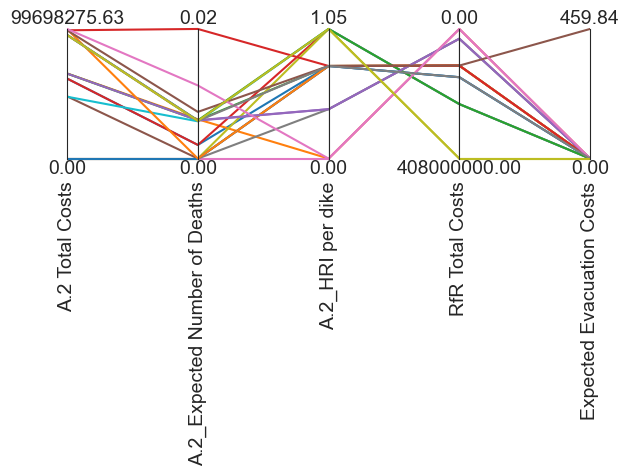

<Figure size 1400x1000 with 0 Axes>

In [53]:
data = combined_results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))
plt.savefig("multi mordm all.png", dpi=300, bbox_inches='tight') # width=12 inches, height=8 inches


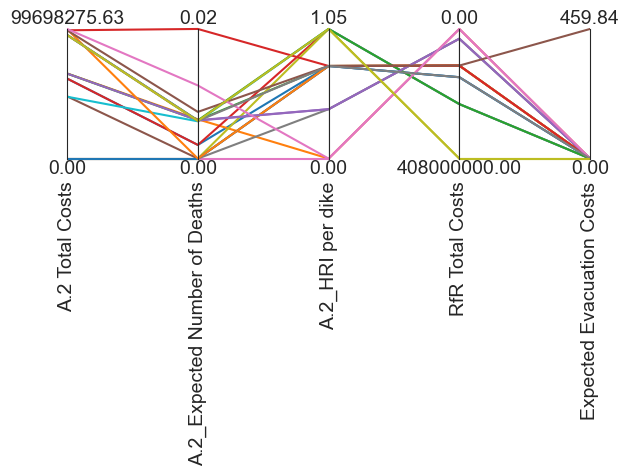

In [54]:

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Invert specific axis
paraxes.invert_axis("RfR Total Costs")

# Save the plot
plt.savefig("mordm_parallel_coordinates.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [55]:



logical = (
    (combined_results["A.2 Total Costs"] < 4e8) &

    (combined_results["A.2_HRI per dike"] > 0.7))



np.sum(logical)
combined_results[logical]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,0,0,0,0,0,0,0,1,0,1,...,7,5,4,4,0,6.153709e+07,0.001796,0.75,151900000.0,0.000000
2,1,0,0,0,0,0,0,1,0,0,...,4,2,4,10,6,6.538148e+07,0.005053,0.75,115300000.0,0.000000
3,0,0,1,0,0,0,0,1,0,1,...,7,1,1,1,5,6.153709e+07,0.001796,1.05,236500000.0,0.000000
5,1,0,0,0,0,0,0,1,0,0,...,1,4,7,3,6,4.784270e+07,0.000000,0.75,115300000.0,0.000000
8,0,0,0,0,0,0,0,1,0,0,...,4,5,4,6,1,0.000000e+00,0.000000,1.05,408000000.0,0.000000
9,1,0,0,0,0,0,0,1,0,0,...,2,5,6,5,6,4.758114e+07,0.004905,1.05,236500000.0,0.000000
10,0,0,0,0,0,0,1,0,0,0,...,4,6,4,6,8,0.000000e+00,0.000000,0.75,151900000.0,0.000000
11,0,1,0,0,0,0,1,0,0,0,...,3,2,5,4,4,9.952540e+07,0.000000,0.75,115300000.0,0.000000
12,0,1,0,0,0,0,1,0,0,0,...,3,1,5,5,4,9.506844e+07,0.005027,1.05,236500000.0,0.000000
13,0,1,0,0,0,0,1,0,0,0,...,3,0,9,10,6,9.869097e+07,0.017069,0.75,115300000.0,0.000000


/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_6145/2740734344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_2["policy"] = results_2.index  # Automatically uses 16, 17, 18 in your case


<Figure size 1400x1000 with 0 Axes>

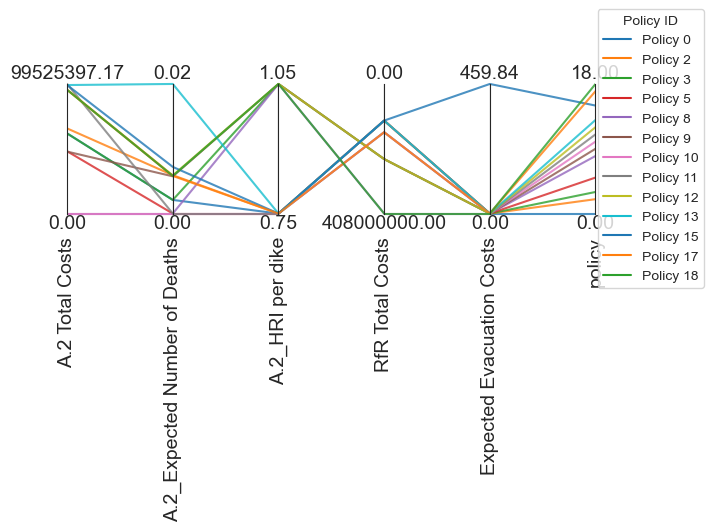

In [56]:

results_2 = combined_results[logical]
results_2["policy"] = results_2.index  # Automatically uses 16, 17, 18 in your case


data = results_2.loc[:, [o.name for o in model.outcomes] + ['policy']]


limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths',
               'RfR Total Costs', 'Expected Evacuation Costs']] = 0


policy_ids = data["policy"].unique()
colors = sns.color_palette("tab10", len(policy_ids))
color_map = dict(zip(policy_ids, colors))


plt.figure(figsize=(14, 10))
paraxes = parcoords.ParallelAxes(limits)

# Plot each policy row with its assigned color
for _, row in data.iterrows():
    policy_id = row["policy"]
    color = color_map.get(policy_id, "gray")
    paraxes.plot(row.to_frame().T, color=color, alpha=0.8)

# Invert axis if needed
paraxes.invert_axis("RfR Total Costs")


legend_handles = [
    Line2D([0], [0], color=color_map[pid], label=f"Policy {pid}")
    for pid in policy_ids
]
plt.legend(handles=legend_handles, title="Policy ID", loc="center left",bbox_to_anchor=(1.02, 0.5),borderaxespad=0)


plt.savefig("parallel_coords_multi_MORDM_selected_policies.png", dpi=300, bbox_inches='tight')
plt.show()

In [57]:
policies = combined_results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,0,1,0,1,...,0,5,5,6,6,7,5,4,4,0
2,1,0,0,0,0,0,0,1,0,0,...,0,5,5,9,6,4,2,4,10,6
3,0,0,1,0,0,0,0,1,0,1,...,0,3,2,9,6,7,1,1,1,5
5,1,0,0,0,0,0,0,1,0,0,...,0,0,7,4,1,1,4,7,3,6
8,0,0,0,0,0,0,0,1,0,0,...,0,4,7,7,5,4,5,4,6,1
9,1,0,0,0,0,0,0,1,0,0,...,0,1,7,6,5,2,5,6,5,6
10,0,0,0,0,0,0,1,0,0,0,...,0,4,4,2,5,4,6,4,6,8
11,0,1,0,0,0,0,1,0,0,0,...,0,7,3,4,1,3,2,5,4,4
12,0,1,0,0,0,0,1,0,0,0,...,0,7,3,4,1,3,1,5,5,4
13,0,1,0,0,0,0,1,0,0,0,...,0,9,3,5,1,3,0,9,10,6


In [58]:
test=combined_results[logical]
test

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,0,0,0,0,0,0,0,1,0,1,...,7,5,4,4,0,6.153709e+07,0.001796,0.75,151900000.0,0.000000
2,1,0,0,0,0,0,0,1,0,0,...,4,2,4,10,6,6.538148e+07,0.005053,0.75,115300000.0,0.000000
3,0,0,1,0,0,0,0,1,0,1,...,7,1,1,1,5,6.153709e+07,0.001796,1.05,236500000.0,0.000000
5,1,0,0,0,0,0,0,1,0,0,...,1,4,7,3,6,4.784270e+07,0.000000,0.75,115300000.0,0.000000
8,0,0,0,0,0,0,0,1,0,0,...,4,5,4,6,1,0.000000e+00,0.000000,1.05,408000000.0,0.000000
9,1,0,0,0,0,0,0,1,0,0,...,2,5,6,5,6,4.758114e+07,0.004905,1.05,236500000.0,0.000000
10,0,0,0,0,0,0,1,0,0,0,...,4,6,4,6,8,0.000000e+00,0.000000,0.75,151900000.0,0.000000
11,0,1,0,0,0,0,1,0,0,0,...,3,2,5,4,4,9.952540e+07,0.000000,0.75,115300000.0,0.000000
12,0,1,0,0,0,0,1,0,0,0,...,3,1,5,5,4,9.506844e+07,0.005027,1.05,236500000.0,0.000000
13,0,1,0,0,0,0,1,0,0,0,...,3,0,9,10,6,9.869097e+07,0.017069,0.75,115300000.0,0.000000


## Hier onder worden de policies gemaakt die getest moeten worden

In [59]:

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [60]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 13 policies * 1 model(s) = 13000 experiments
100%|████████████████████████████████████| 13000/13000 [12:16<00:00, 17.66it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [61]:
results

(       A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
 0                           34  149.159312      10.0   0.658194  191.738012   
 1                           23  313.983599       1.0   0.662702  238.986907   
 2                           20  265.551946       1.5   0.604346   61.254989   
 3                           42  313.046711       1.5   0.678046  172.755805   
 4                            9  312.542950       1.0   0.641815   89.878241   
 ...                        ...         ...       ...        ...         ...   
 12995                       11  320.241928      10.0   0.946700  152.081883   
 12996                        5  157.761776      10.0   0.333960  196.478114   
 12997                       72  245.991951       1.5   0.715541  317.855920   
 12998                       71   87.192209       1.5   0.140137  173.108225   
 12999                      112  168.472913       1.0   0.479570  117.577296   
 
       A.2_Brate  A.2_pfail    A.3_Bma

In [62]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [63]:
from ema_workbench import ScalarOutcome

experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,2.670367e+15,2.782703e-04,3.177306,151900000.0,0.000000e+00
10,2.109564e+16,1.624923e-02,0.747693,151900000.0,0.000000e+00
11,1.107354e+14,1.016696e-07,0.750000,115300000.0,0.000000e+00
12,1.736751e+14,3.708451e-07,33.188891,236500000.0,0.000000e+00
13,4.735810e+14,4.219411e-06,10.562330,115300000.0,0.000000e+00
15,4.311782e+14,4.633444e-07,10.562330,115300000.0,4.934078e+06
17,1.574617e+14,2.413368e-07,23.697311,151900000.0,0.000000e+00
18,1.574617e+14,2.413368e-07,33.188891,408000000.0,0.000000e+00
2,3.008085e+15,3.591005e-04,2.989097,115300000.0,0.000000e+00
3,2.671045e+15,2.786987e-04,4.540956,236500000.0,0.000000e+00


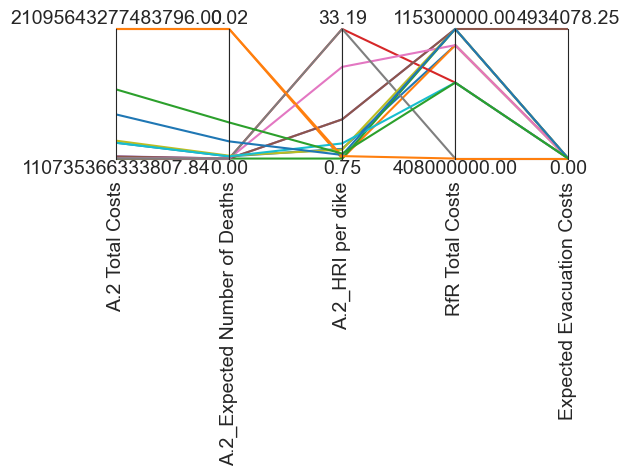

In [64]:
data = scores
limits = parcoords.get_limits(data)


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")

plt.show()

In [65]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

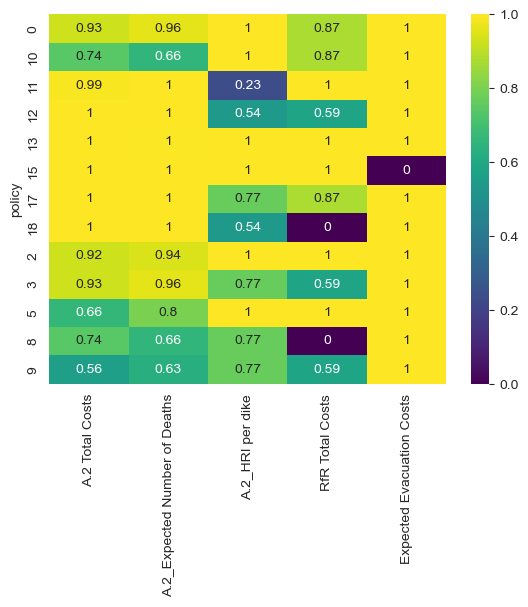

In [66]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("regret multi mordm.png", dpi=300, bbox_inches='tight')
plt.show()

In [67]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,34,149.159312,10.0,0.658194,191.738012,1.0,0.671873,231.749768,1.0,0.263554,...,6,6,7,5,4,4,0,3000,0,dikesnet
1,23,313.983599,1.0,0.662702,238.986907,1.5,0.521530,259.520796,1.5,0.500363,...,6,6,7,5,4,4,0,3001,0,dikesnet
2,20,265.551946,1.5,0.604346,61.254989,10.0,0.677601,271.175939,1.0,0.976749,...,6,6,7,5,4,4,0,3002,0,dikesnet
3,42,313.046711,1.5,0.678046,172.755805,1.5,0.813510,307.914891,1.5,0.382902,...,6,6,7,5,4,4,0,3003,0,dikesnet
4,9,312.542950,1.0,0.641815,89.878241,1.0,0.528544,172.976694,10.0,0.075066,...,6,6,7,5,4,4,0,3004,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,11,320.241928,10.0,0.946700,152.081883,1.0,0.845168,197.765113,1.0,0.567507,...,5,2,7,6,6,4,6,3995,18,dikesnet
12996,5,157.761776,10.0,0.333960,196.478114,1.5,0.143993,243.652608,10.0,0.521483,...,5,2,7,6,6,4,6,3996,18,dikesnet
12997,72,245.991951,1.5,0.715541,317.855920,1.0,0.748887,166.189232,10.0,0.905614,...,5,2,7,6,6,4,6,3997,18,dikesnet
12998,71,87.192209,1.5,0.140137,173.108225,10.0,0.934752,79.825955,10.0,0.141665,...,5,2,7,6,6,4,6,3998,18,dikesnet


In [68]:
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,0,1,0,1,...,0,5,5,6,6,7,5,4,4,0
2,1,0,0,0,0,0,0,1,0,0,...,0,5,5,9,6,4,2,4,10,6
3,0,0,1,0,0,0,0,1,0,1,...,0,3,2,9,6,7,1,1,1,5
5,1,0,0,0,0,0,0,1,0,0,...,0,0,7,4,1,1,4,7,3,6
8,0,0,0,0,0,0,0,1,0,0,...,0,4,7,7,5,4,5,4,6,1
9,1,0,0,0,0,0,0,1,0,0,...,0,1,7,6,5,2,5,6,5,6
10,0,0,0,0,0,0,1,0,0,0,...,0,4,4,2,5,4,6,4,6,8
11,0,1,0,0,0,0,1,0,0,0,...,0,7,3,4,1,3,2,5,4,4
12,0,1,0,0,0,0,1,0,0,0,...,0,7,3,4,1,3,1,5,5,4
13,0,1,0,0,0,0,1,0,0,0,...,0,9,3,5,1,3,0,9,10,6


In [69]:
policies.to_csv("multi-scenario_policies.csv", index=True)


## PRIM analyse met multi scenario policies voor robustness

In [70]:
# lees de CSV in met de gevonden policies vanuit de MORDM
policies_multiscenario = pd.read_csv("multi-scenario_policies.csv")

# zet elke rij om in een Policy-object
multiscenario_policies = [
    Policy(f"cand_{i}", **row.to_dict())
    for i, row in policies_multiscenario.iterrows()

    ]


In [71]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)

    df_pols = pd.read_csv("multi-scenario_policies.csv")

    # policies = [
    #     Policy(f"policy_{i}", **row.to_dict())
    #     for i, row in df_pols.iterrows()
    # ]

    scenarios=1000
    policies=multiscenario_policies #policies retrieved from multi scenario MORDM
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=policies )

        experiments, outcomes = results

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 1000 scenarios * 13 policies * 1 model(s) = 13000 experiments
100%|████████████████████████████████████| 13000/13000 [12:09<00:00, 17.83it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [72]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,125,204.981495,1.5,0.896580,138.600205,10.0,0.311765,217.139837,1.5,0.118164,...,6,6,7,5,4,4,0,4000,cand_0,dikesnet
1,99,278.687530,10.0,0.183310,93.816122,10.0,0.504689,96.070830,1.0,0.003097,...,6,6,7,5,4,4,0,4001,cand_0,dikesnet
2,35,233.142326,10.0,0.306650,62.472429,1.5,0.686211,332.077814,1.5,0.205457,...,6,6,7,5,4,4,0,4002,cand_0,dikesnet
3,109,302.736676,1.0,0.924805,307.731890,10.0,0.959052,328.755308,1.0,0.487126,...,6,6,7,5,4,4,0,4003,cand_0,dikesnet
4,111,105.676060,1.5,0.349662,273.032899,10.0,0.931011,227.734947,1.5,0.709437,...,6,6,7,5,4,4,0,4004,cand_0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,74,162.383165,1.5,0.207563,115.254794,1.0,0.131305,324.212702,1.0,0.025352,...,5,2,7,6,6,4,6,4995,cand_12,dikesnet
12996,121,169.732192,10.0,0.434785,197.760188,1.0,0.737171,68.909289,10.0,0.013057,...,5,2,7,6,6,4,6,4996,cand_12,dikesnet
12997,0,69.396434,10.0,0.883777,311.350581,1.0,0.440450,309.802687,1.5,0.049302,...,5,2,7,6,6,4,6,4997,cand_12,dikesnet
12998,67,199.264974,1.5,0.585641,259.167934,1.0,0.911675,116.398756,1.5,0.694265,...,5,2,7,6,6,4,6,4998,cand_12,dikesnet


In [73]:
results_per_policy = {}

hri_baseline=baseline_outcomes["A.2_HRI per dike"]
hri_sys = outcomes["A.2_HRI per dike"]
hri_q25 = np.percentile(hri_baseline, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
cost_baseline=baseline_outcomes["A.2 Total Costs"]
cost_total = outcomes["A.2 Total Costs"] # (N,)
cost_q75 = np.percentile(cost_baseline, 75)
target_cost = cost_total >= cost_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

        # ---- 2.4 Combineer tot één worst-case target ----
y = target_hri | target_cost
y


array([False, False, False, ..., False, False, False])

In [74]:
for pol in multiscenario_policies:

    pol_name = pol.name

    # selecteer alleen de runs met exact die naam
    mask_pol = experiments["policy"] == pol_name
    X_pol   = experiments.loc[mask_pol, [u.name for u in model.uncertainties]]
    y_pol   = y[mask_pol]

    # 3) sanity‐checks
    # 3) sanity‐checks
    print(f"Policy {pol.name!r}: {len(X_pol)} runs (y=True: {y_pol.sum()}, y=False: {len(y_pol)-y_pol.sum()})")

    if len(X_pol) == 0:
        print("  → geen runs met deze policy, overslaan")
        continue

    if not (y_pol.dtype == bool):
        y_pol = y_pol.astype(bool)

    if y_pol.sum() == 0 or y_pol.sum() == len(y_pol):
        print("  → y bevat niet zowel True als False, overslaan")
        continue

    # 2) maak en run PRIM
    prim_alg = prim.Prim(
        X_pol,
        y_pol,
        threshold=0.6,       # kies zelf je cover‐of‐density cut‐off
        peel_alpha=0.05,     # hoe “agressief” peel je
        mass_min=0.1        # minimale fractie runs in box
    )
    box = prim_alg.find_box()

    box.inspect()
    #box.show_tradeoff()

    traj = box.peeling_trajectory


    # 3) bewaar je result voor latere vergelijking
    results_per_policy[pol_name] = {
        "prim_alg":   prim_alg,
        "selected_box": box,
        "trajectory":   traj,
    }
        # "box_id": int(traj.score.idxmax())

[MainProcess/INFO] 1000 points remaining, containing 21 cases of interest


Policy 'cand_0': 1000 runs (y=True: 21, y=False: 979)


[MainProcess/INFO] box mean (0.20588235294117646) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 1000 points remaining, containing 28 cases of interest


coverage       1.000
density        0.021
id             0.000
k             21.000
mass           1.000
mean           0.021
n           1000.000
res_dim        0.000
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []

Policy 'cand_1': 1000 runs (y=True: 28, y=False: 972)


[MainProcess/INFO] box mean (0.27450980392156865) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 1000 points remaining, containing 21 cases of interest


coverage       1.000
density        0.028
id             0.000
k             28.000
mass           1.000
mean           0.028
n           1000.000
res_dim        0.000
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []

Policy 'cand_2': 1000 runs (y=True: 21, y=False: 979)


[MainProcess/INFO] box mean (0.20588235294117646) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 1000 points remaining, containing 73 cases of interest


coverage       1.000
density        0.021
id             0.000
k             21.000
mass           1.000
mean           0.021
n           1000.000
res_dim        0.000
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []

Policy 'cand_3': 1000 runs (y=True: 73, y=False: 927)


[MainProcess/INFO] mean: 0.7156862745098039, mass: 0.102, coverage: 1.0, density: 0.7156862745098039 restricted_dimensions: 3
[MainProcess/INFO] 1000 points remaining, containing 174 cases of interest


coverage      1.000000
density       0.715686
id           43.000000
k            73.000000
mass          0.102000
mean          0.715686
n           102.000000
res_dim       3.000000
Name: 43, dtype: float64

                           box 43                                    
                              min         max  qp value      qp value
A.2_pfail                0.000124    0.111004       NaN  4.998312e-56
A.0_ID flood wave shape  0.000000  125.000000       NaN  3.713241e-01
A.1_pfail                0.049880    0.999632  0.227675           NaN

Policy 'cand_4': 1000 runs (y=True: 174, y=False: 826)


[MainProcess/INFO] mean: 0.9492753623188406, mass: 0.138, coverage: 0.7528735632183908, density: 0.9492753623188406 restricted_dimensions: 4
[MainProcess/INFO] 1000 points remaining, containing 108 cases of interest


coverage      0.752874
density       0.949275
id           48.000000
k           131.000000
mass          0.138000
mean          0.949275
n           138.000000
res_dim       4.000000
Name: 48, dtype: float64

                           box 48                                        
                              min         max      qp value      qp value
A.2_pfail                0.000124    0.185274           NaN  1.089419e-75
A.1_pfail                0.264349    0.999632  1.920441e-07           NaN
A.3_pfail                0.007888    0.999206  3.316497e-01           NaN
A.0_ID flood wave shape  2.000000  132.000000  5.987475e-01           NaN

Policy 'cand_5': 1000 runs (y=True: 108, y=False: 892)


[MainProcess/INFO] mean: 0.9333333333333333, mass: 0.105, coverage: 0.9074074074074074, density: 0.9333333333333333 restricted_dimensions: 2
[MainProcess/INFO] 1000 points remaining, containing 174 cases of interest


coverage      0.907407
density       0.933333
id           46.000000
k            98.000000
mass          0.105000
mean          0.933333
n           105.000000
res_dim       2.000000
Name: 46, dtype: float64

             box 46                                  
                min       max  qp value      qp value
A.2_pfail  0.000124  0.112889       NaN  2.486102e-82
A.1_pfail  0.070644  0.999632  0.024674           NaN

Policy 'cand_6': 1000 runs (y=True: 174, y=False: 826)


[MainProcess/INFO] mean: 0.9492753623188406, mass: 0.138, coverage: 0.7528735632183908, density: 0.9492753623188406 restricted_dimensions: 4
[MainProcess/INFO] 1000 points remaining, containing 1 cases of interest
[MainProcess/INFO] box mean (0.00909090909090909) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 1000 points remaining, containing 1 cases of interest
[MainProcess/INFO] box mean (0.00909090909090909) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 1000 points remaining, containing 2 cases of interest
[MainProcess/INFO] box mean (0.01818181818181818) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 1000 points remaining, containing 2 cases of interest


coverage      0.752874
density       0.949275
id           48.000000
k           131.000000
mass          0.138000
mean          0.949275
n           138.000000
res_dim       4.000000
Name: 48, dtype: float64

                           box 48                                        
                              min         max      qp value      qp value
A.2_pfail                0.000124    0.185274           NaN  1.089419e-75
A.1_pfail                0.264349    0.999632  1.920441e-07           NaN
A.3_pfail                0.007888    0.999206  3.316497e-01           NaN
A.0_ID flood wave shape  2.000000  132.000000  5.987475e-01           NaN

Policy 'cand_7': 1000 runs (y=True: 1, y=False: 999)
coverage       1.000
density        0.001
id             0.000
k              1.000
mass           1.000
mean           0.001
n           1000.000
res_dim        0.000
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: 

[MainProcess/INFO] box mean (0.01818181818181818) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 1000 points remaining, containing 1 cases of interest
[MainProcess/INFO] box mean (0.00909090909090909) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 1000 points remaining, containing 1 cases of interest
[MainProcess/INFO] box mean (0.00909090909090909) does not meet threshold criteria (1 0.6),returning dump box


coverage       1.000
density        0.002
id             0.000
k              2.000
mass           1.000
mean           0.002
n           1000.000
res_dim        0.000
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []

Policy 'cand_11': 1000 runs (y=True: 1, y=False: 999)
coverage       1.000
density        0.001
id             0.000
k              1.000
mass           1.000
mean           0.001
n           1000.000
res_dim        0.000
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []

Policy 'cand_12': 1000 runs (y=True: 1, y=False: 999)
coverage       1.000
density        0.001
id             0.000
k              1.000
mass           1.000
mean           0.001
n           1000.000
res_dim        0.000
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []



In [75]:
# 1) lijst van alle uncertainty-kolommen
cols_unc = [u.name for u in model.uncertainties]

# 2) per kolom zelf min/max bepalen, alleen als 'ie numeriek is
global_ranges = {}
for var in cols_unc:
    ser = experiments[var]
    if is_numeric_dtype(ser):
        lo = ser.min()
        hi = ser.max()
        global_ranges[var] = (lo, hi)
    else:
        # categoricals slaan we over, of bewaar je volledige domain als set:
        cats = ser.cat.categories if hasattr(ser.dtype, "categories") else None
        print(f"  → sla {var!r} over (dtype={ser.dtype})")

# 3) print ter controle
for var, (lo, hi) in global_ranges.items():
    print(f"{var:30s}  glob_min = {lo:8.3f},  glob_max = {hi:8.3f}")

  → sla 'discount rate 0' over (dtype=category)
  → sla 'discount rate 1' over (dtype=category)
  → sla 'discount rate 2' over (dtype=category)
  → sla 'A.1_Brate' over (dtype=category)
  → sla 'A.2_Brate' over (dtype=category)
  → sla 'A.3_Brate' over (dtype=category)
  → sla 'A.4_Brate' over (dtype=category)
  → sla 'A.5_Brate' over (dtype=category)
A.0_ID flood wave shape         glob_min =    0.000,  glob_max =  132.000
A.1_Bmax                        glob_min =   30.231,  glob_max =  349.839
A.1_pfail                       glob_min =    0.000,  glob_max =    1.000
A.2_Bmax                        glob_min =   30.268,  glob_max =  349.880
A.2_pfail                       glob_min =    0.000,  glob_max =    0.999
A.3_Bmax                        glob_min =   30.224,  glob_max =  349.871
A.3_pfail                       glob_min =    0.001,  glob_max =    0.999
A.4_Bmax                        glob_min =   30.022,  glob_max =  349.929
A.4_pfail                       glob_min =    0.001,  

In [76]:
overall = (
    experiments
      .groupby("policy")
      .apply(lambda df: y[df.index].mean())
      .rename("overall_fail_rate")
)

# --- 2) verzamel PRIM‐metrics uit de geselecteerde box voor elke policy ---
box_info = []
for pol, info in results_per_policy.items():
    box = info["selected_box"]   # dit is een PrimBox
    box_info.append({
        "policy":   pol,
        "coverage": box.coverage,
        "density":  box.density,
        "res_dim":  box.res_dim,
        "mass":     box.mass
    })

box_df = pd.DataFrame(box_info).set_index("policy")

# --- 3) combineer alles in één rapport-DataFrame ---
report = pd.concat([overall, box_df], axis=1)

# zet de fracties om in percentages
report["overall_fail_%"]       = report.overall_fail_rate * 100
report["box_covers_%"]         = report.coverage        * 100
report["fail_in_box_%"]        = report.density         * 100

# selecteer en sorteer kolommen
report = report[[
    "overall_fail_%",
    "box_covers_%",
    "fail_in_box_%",
    "res_dim",
    "mass"
]].sort_values("overall_fail_%", ascending=False)

# afronden op 1 decimaal
report = report.round(1)

report

/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_6145/3877888085.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("policy")


,overall_fail_%,box_covers_%,fail_in_box_%,res_dim,mass
policy,,,,,
cand_4,17.4,75.3,94.9,4,0.1
cand_6,17.4,75.3,94.9,4,0.1
cand_5,10.8,90.7,93.3,2,0.1
cand_3,7.3,100.0,71.6,3,0.1
cand_1,2.8,100.0,2.8,0,1.0
cand_0,2.1,100.0,2.1,0,1.0
cand_2,2.1,100.0,2.1,0,1.0
cand_10,0.2,100.0,0.2,0,1.0
cand_9,0.2,100.0,0.2,0,1.0


In [77]:
# names of all levers in the model
lever_names = [lev.name for lev in model.levers]

# pick the policy you want to inspect
pol_name = "cand_1"          # or any other policy name

# show the lever settings for that policy (one row per scenario)
experiments.loc[experiments["policy"] == pol_name, lever_names]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
1000,1,0,0,0,0,0,0,1,0,0,...,0,5,5,9,6,4,2,4,10,6
1001,1,0,0,0,0,0,0,1,0,0,...,0,5,5,9,6,4,2,4,10,6
1002,1,0,0,0,0,0,0,1,0,0,...,0,5,5,9,6,4,2,4,10,6
1003,1,0,0,0,0,0,0,1,0,0,...,0,5,5,9,6,4,2,4,10,6
1004,1,0,0,0,0,0,0,1,0,0,...,0,5,5,9,6,4,2,4,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,0,0,0,0,0,1,0,0,...,0,5,5,9,6,4,2,4,10,6
1996,1,0,0,0,0,0,0,1,0,0,...,0,5,5,9,6,4,2,4,10,6
1997,1,0,0,0,0,0,0,1,0,0,...,0,5,5,9,6,4,2,4,10,6
1998,1,0,0,0,0,0,0,1,0,0,...,0,5,5,9,6,4,2,4,10,6
